In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [2]:
!wget https://www.dropbox.com/scl/fi/ln64xjqlwd4665u9sp2bq/Full_Dataset.rar?rlkey=g5aa4zefy2xpj98n3x8ihjcp2&st=bg907w5p&dl=0
!mv Full_Dataset.rar?rlkey=g5aa4zefy2xpj98n3x8ihjcp2 Full_Dataset.rar
!unrar x /content/Full_Dataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  Full_Dataset/55.txt                                           72%  OK 
Extracting  Full_Dataset/550.txt                                          72%  OK 
Extracting  Full_Dataset/5500.txt                                         72%  OK 
Extracting  Full_Dataset/5501.txt                                         72%  OK 
Extracting  Full_Dataset/5502.txt                                         72%  OK 
Extracting  Full_Dataset/5503.txt                                         72%  OK 
Extracting  Full_Dataset/5504.txt                                         72%  OK 
Extracting  Full_Dataset/5505.txt                                         72%  OK 
Extracting  Full_Dataset/5506.txt                                         72%  OK 
Extracting  Full_Dataset/5507.txt                                         72%  OK 
Extracting  Full_Dataset/5508

In [3]:
!wget https://raw.githubusercontent.com/HaniehP/PersianNER/refs/heads/master/glove300d.txt.zip
!unzip /content/glove300d.txt.zip

--2024-12-06 14:32:24--  https://raw.githubusercontent.com/HaniehP/PersianNER/refs/heads/master/glove300d.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53542816 (51M) [application/zip]
Saving to: ‘glove300d.txt.zip’

glove300d.txt.zip   100%[===================>]  51.06M   128MB/s    in 0.4s    

2024-12-06 14:32:26 (128 MB/s) - ‘glove300d.txt.zip’ saved [53542816/53542816]

Archive:  /content/glove300d.txt.zip
  inflating: glove300d.txt           


In [4]:
# Path to the folder containing the text files
folder_path = 'Full_Dataset'

# Initialize empty lists to store text and labels
raw_train_ds = []
labels_ds = []

# List the files in the folder
files = os.listdir(folder_path)

# Iterate over the first 10 files
for file_name in files:
    # Construct the full path to the file
    file_path = os.path.join(folder_path, file_name)

    # Open the text file in read mode with UTF-8 encoding
    with open(file_path, 'r', encoding='utf-8') as file:
        # Initialize empty strings to store text and label for current file
        text = ''
        label = []

        # Iterate through each line in the file
        for line in file:
            # Get the last character of the line
            last_char = line.strip()[-1:]
            # Append the last character to the label
            label.append(int(last_char))

            # Get the rest of the line (excluding the last character)
            rest_of_line = line.strip()[:-1]
            # Append the rest of the line to the text
            text += rest_of_line

        # Append the text and label for the current file to the lists
        raw_train_ds.append(text)
        labels_ds.append(label)

In [5]:
train_size = 0.8

size = len(raw_train_ds)

train_samples = int(size * train_size)

x_train, y_train = raw_train_ds[:train_samples], labels_ds[:train_samples]
x_valid, y_valid = raw_train_ds[train_samples:], labels_ds[train_samples:]

In [6]:
# Load GloVe embeddings
embedding_index = {}
with open('glove300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
        except ValueError:
            continue

In [7]:
# Parameters
max_tokens = 10000
output_sequence_length = 50
embedding_dim = 300
num_classes = len(set([label for sublist in y_train for label in sublist]))

In [8]:
# Create TextVectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorize_layer.adapt(x_train)

In [9]:
# Vectorize and pad labels
x_train_vectorized = vectorize_layer(x_train)
x_valid_vectorized = vectorize_layer(x_valid)

y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=output_sequence_length, padding='post')
y_valid_padded = tf.keras.preprocessing.sequence.pad_sequences(y_valid, maxlen=output_sequence_length, padding='post')

In [10]:
# Create embedding matrix
vocab = vectorize_layer.get_vocabulary()
word_index = {word: i for i, word in enumerate(vocab)}
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
# Input and embedding layer
input = Input(shape=(output_sequence_length,))
embedding_layer = Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=output_sequence_length,
    trainable=True  # Allow fine-tuning to better adapt to the task
)(input)

# Initial dropout (reduced to allow more signal through)
x = Dropout(0.1)(embedding_layer)

# CNN layers with increased filters for better feature extraction
conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(x)

# Combine CNN outputs
x = tf.keras.layers.Concatenate()([conv1, conv2])
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.1)(x)  # Reduced dropout

# Bidirectional LSTM with increased units
x = Bidirectional(LSTM(
    units=128,  # Increased units
    return_sequences=True,
    recurrent_dropout=0.1
))(x)

# Output layers
x = Dropout(0.1)(x)  # Reduced dropout
x = TimeDistributed(Dense(128, activation='relu'))(x)  # Increased units
x = Dropout(0.1)(x)
output = TimeDistributed(Dense(num_classes, activation='softmax'))(x)

model = Model(inputs=input, outputs=output)

# Modified focal loss with adjusted alpha to focus more on positive class
def sequence_focal_loss(gamma=2., alpha=0.75):  # Increased alpha for positive class
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Higher weight for positive class
        pos_weight = alpha
        neg_weight = 1 - alpha

        weights = y_true_one_hot * pos_weight + (1 - y_true_one_hot) * neg_weight

        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        focal_weight = weights * tf.math.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    return loss

# Compile with modified settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=2e-4,  # Slightly increased learning rate
        clipnorm=1.0
    ),
    loss=sequence_focal_loss(gamma=2.0, alpha=0.75)  # Increased alpha
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 300)        │      3,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 300)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 50, 128)        │        115,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 50, 128)        │        192,128 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 50, 256)        │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 256)        │          1,024 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 256)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        394,240 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 50, 128)        │         32,896 │ dropout_2[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 50, 128)        │              0 │ time_distributed[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 50, 2)          │            258 │ dropout_3[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,735,874 (14.25 MB)

 Trainable params: 3,735,362 (14.25 MB)

 Non-trainable params: 512 (2.00 KB)

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Define a custom callback for precision, recall, F1-score, and accuracy per sentence
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        y_pred = self.model.predict(val_x)

        # Convert predictions to class labels
        y_pred_classes = y_pred.argmax(axis=-1)

        # Flatten the arrays for token-level metrics
        val_y_flat = val_y.flatten()
        y_pred_flat = y_pred_classes.flatten()

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(val_y_flat, y_pred_flat)
        TP = conf_matrix[1, 1]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]

        # Precision, Recall, and F1-Score for Class 1
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        # Calculate sentence-level accuracy
        correct_sentences = np.all(val_y == y_pred_classes, axis=1)  # Compare token-level labels for each sentence
        sentence_accuracy = np.mean(correct_sentences)  # Percentage of completely correct sentences

        # Print metrics
        print(f"\nEpoch {epoch + 1}:")
        print(f"Precision (Class 1): {precision:.4f}, Recall (Class 1): {recall:.4f}, F1-Score (Class 1): {f1:.4f}")
        print(f"Sentence-Level Accuracy: {sentence_accuracy:.4f}")


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',  # Path to save the best weights
    monitor='val_loss',               # Metric to monitor
    save_best_only=True,              # Save only the best weights
    save_weights_only=True,           # Save weights instead of the full model
    mode='min',                       # 'min' for metrics where lower is better
    verbose=1                         # Verbosity level
)

In [15]:
# Train the model
batch_size = 64
epochs = 15

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_vectorized, y_train_padded)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid_vectorized, y_valid_padded)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

metrics_callback = MetricsCallback(validation_data=(x_valid_vectorized, y_valid_padded))


# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[metrics_callback, checkpoint],
)

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step

Epoch 1:
Precision (Class 1): 0.6316, Recall (Class 1): 0.1091, F1-Score (Class 1): 0.1861
Sentence-Level Accuracy: 0.7485

Epoch 1: val_loss improved from inf to 0.00760, saving model to best_model.weights.h5
229/229 ━━━━━━━━━━━━━━━━━━━━ 67s 220ms/step - loss: 0.0165 - val_loss: 0.0076
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step

Epoch 2:
Precision (Class 1): 0.7112, Recall (Class 1): 0.3019, F1-Score (Class 1): 0.4238
Sentence-Level Accuracy: 0.7772

Epoch 2: val_loss improved from 0.00760 to 0.00650, saving model to best_model.weights.h5
229/229 ━━━━━━━━━━━━━━━━━━━━ 71s 210ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step

Epoch 3:
Precision (Class 1): 0.7130, Recall (Class 1): 0.3733, F1-Score (Class 1): 0.4901
Sentence-Level Accuracy: 0.7915

Epoch 3: val_loss improved from 0.00650 to 0.00622, saving model to best_model.weights.h5
229/229 ━━━━━━━━━━━━━━━━━━━━ 47s 204ms/step 

In [16]:
# Predict on validation set
y_pred = model.predict(x_valid_vectorized).argmax(axis=-1)

# Flatten the arrays for token-level metrics
val_y_flat = y_valid_padded.flatten()
y_pred_flat = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_y_flat, y_pred_flat)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Precision, Recall, and F1-Score for Class 1
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Sentence-Level Accuracy
correct_sentences = np.all(y_valid_padded == y_pred, axis=1)  # Check if all tokens in each sentence are correct
sentence_accuracy = np.mean(correct_sentences)  # Percentage of completely correct sentences

# Print metrics
print(f'Validation Precision (Class 1): {precision:.4f}')
print(f'Validation Recall (Class 1): {recall:.4f}')
print(f'Validation F1-Score (Class 1): {f1:.4f}')
print(f'Sentence-Level Accuracy: {sentence_accuracy:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
Validation Precision (Class 1): 0.7784
Validation Recall (Class 1): 0.6176
Validation F1-Score (Class 1): 0.6887
Sentence-Level Accuracy: 0.8643


In [17]:
# Define the function to preprocess and predict NER tags for a single input string
def predict_ner_tags(input_string, vectorize_layer, model, max_length=50):
    # Tokenize the input string
    tokenized_input = input_string.split()

    # Vectorize the tokenized input
    input_vectorized = vectorize_layer(' '.join(tokenized_input))

    # Pad the vectorized input to the same length as used during training
    input_vectorized = tf.keras.preprocessing.sequence.pad_sequences([input_vectorized], maxlen=max_length, padding='post')

    # Make predictions
    predictions = model.predict(input_vectorized)

    # Post-process predictions to get the labels
    predicted_labels = tf.argmax(predictions, axis=-1).numpy()[0]

    # Only show labels for the original input length
    return list(zip(tokenized_input, predicted_labels[:len(tokenized_input)]))

In [18]:
# Example usage of the prediction function
input_sentences = [
    "مهدی صالحی، وزیر صنعت، معدن و تجارت، امروز به دیدار علیرضا رحیمی مدیر فناوری اطلاعاتی رفت.",
    "دکتر حسینی، استاد دانشگاه تهران، در مورد تکنیک‌های یادگیری عمیق مقاله‌ای منتشر کرد.",
    "فرزاد نوری، مدیر عامل شرکت ارتباطات پیشرفته، از آغاز طرح جدید خود خبر داد.",
    "دانیال نیکو، بازیکن تیم ملی فوتبال ایران، به خاطر حضور در مسابقات بین‌المللی تشویق شد.",
    "سوسن افشار، بازیگر معروف سینما و تلویزیون، امشب در برنامه خندوانه حاضر خواهد شد.",
    "حسن روحانی ، به روحانی محل ، رشوه داد .",
]
for input_string in input_sentences:
    predicted_ner_tags = predict_ner_tags(input_string, vectorize_layer, model)

    # Print the results
    for word, label in predicted_ner_tags:
        print(f"{word}: {label}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
مهدی: 1
صالحی،: 1
وزیر: 0
صنعت،: 0
معدن: 0
و: 0
تجارت،: 0
امروز: 0
به: 0
دیدار: 0
علیرضا: 1
رحیمی: 1
مدیر: 0
فناوری: 0
اطلاعاتی: 0
رفت.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
دکتر: 0
حسینی،: 1
استاد: 0
دانشگاه: 0
تهران،: 0
در: 0
مورد: 0
تکنیک‌های: 0
یادگیری: 0
عمیق: 0
مقاله‌ای: 0
منتشر: 0
کرد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
فرزاد: 1
نوری،: 1
مدیر: 0
عامل: 0
شرکت: 0
ارتباطات: 0
پیشرفته،: 0
از: 0
آغاز: 0
طرح: 0
جدید: 0
خود: 0
خبر: 0
داد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
دانیال: 1
نیکو،: 1
بازیکن: 0
تیم: 0
ملی: 0
فوتبال: 0
ایران،: 0
به: 0
خاطر: 0
حضور: 0
در: 0
مسابقات: 0
بین‌المللی: 0
تشویق: 0
شد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
سوسن: 1
افشار،: 1
بازیگر: 0
معروف: 0
سینما: 0
و: 0
تلویزیون،: 0
امشب: 0
در: 0
برنامه: 0
خندوانه: 0
حاضر: 0
خواهد: 0
شد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
حسن: 1
روحانی: 1
،: 0
به: 0
روحانی: 0
محل: 0
،: 0
رشوه: 0
داد: 0
.: 0



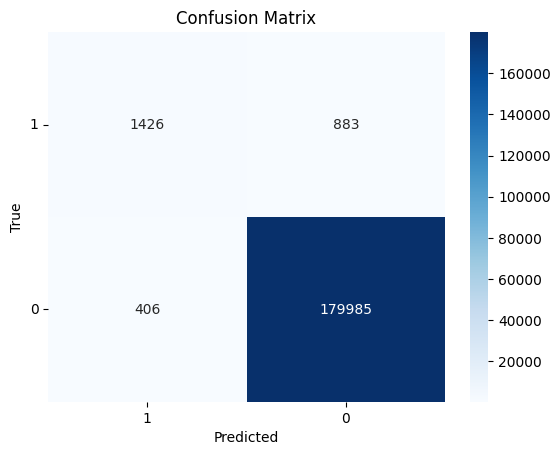

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true_flat = y_valid_padded.flatten()
y_pred_flat = y_pred.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Swap rows and columns to change the order
cm = cm[[1, 0], :]  # Swap rows
cm = cm[:, [1, 0]]  # Swap columns

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['1', '0'])  # Update x-axis labels
plt.yticks([0.5, 1.5], ['1', '0'], rotation=0)  # Update y-axis labels
plt.show()


In [20]:
# Assuming 'vectorize_layer' is your TextVectorization layer
# Add the vectorize_layer to the model architecture
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)  # Assuming input is text (string)
x = vectorize_layer(inputs)  # Apply vectorization
outputs = model(x)  # Pass the vectorized input to the rest of the model

# Create a new model with the vectorize layer
model_with_preprocessing = tf.keras.Model(inputs, outputs)

# Save the model with preprocessing included
model_with_preprocessing.save('ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.h5')

# Optionally, zip the model folder
!zip -r /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.zip /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.keras

	zip warning: name not matched: /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.keras

zip error: Nothing to do! (try: zip -r /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.zip . -i /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.keras)


In [22]:
# prompt: load the saved model

import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.h5', compile=False)

# Now you can use the 'loaded_model' to make predictions
# Example:
# predictions = loaded_model.predict(some_input_data)

In [23]:
# prompt: print model layers

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 300)        │      3,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 300)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 50, 128)        │        115,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 50, 128)        │        192,128 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 50, 256)        │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 256)        │          1,024 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 256)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        394,240 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 256)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 50, 128)        │         32,896 │ dropout_2[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 50, 128)        │              0 │ time_distributed[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 50, 2)          │            258 │ dropout_3[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,206,600 (42.75 MB)

 Trainable params: 3,735,362 (14.25 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 7,470,726 (28.50 MB)

In [24]:
# prompt: save vectorized layer

import tensorflow as tf

# Assuming 'vectorize_layer' is your TextVectorization layer
# Add the vectorize_layer to the model architecture
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)  # Assuming input is text (string)
x = vectorize_layer(inputs)  # Apply vectorization
outputs = model(x)  # Pass the vectorized input to the rest of the model

# Create a new model with the vectorize layer
model_with_preprocessing = tf.keras.Model(inputs, outputs)

# Save the model with preprocessing included
model_with_preprocessing.save('ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.h5')

# Optionally, zip the model folder
!zip -r /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.zip /content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.h5

  adding: content/ner_model_with_preprocessor_pretrained_embedding_cnn_focalloss.h5 (deflated 7%)


In [26]:
# Save the model weights
model.save_weights('model_weights.weights.h5')

In [27]:
import pickle

# Save training data and vectorize layer
training_data = {
    'x_train': x_train,
    'vectorize_config': vectorize_layer.get_config(),
    'vectorize_weights': vectorize_layer.get_weights()
}

with open('training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

In [28]:
import pickle

# Save training data, vectorize layer and embedding matrix
training_data = {
    'x_train': x_train,
    'vectorize_config': vectorize_layer.get_config(),
    'vectorize_weights': vectorize_layer.get_weights(),
    'embedding_matrix': embedding_matrix  # اضافه کردن embedding matrix
}

# Save the data
with open('training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

# # Save the model weights
# model.save_weights('model_weights.weights.h5')

In [29]:
import pickle

# Save all necessary data
training_data = {
    'x_train': x_train,
    'vectorize_config': vectorize_layer.get_config(),
    'vectorize_weights': vectorize_layer.get_weights(),
    'embedding_matrix': embedding_matrix,
    'vocab_size': len(vocab),  # اضافه کردن سایز vocabulary
    'max_tokens': max_tokens,  # اضافه کردن max_tokens
    'embedding_dim': embedding_dim,
    'max_sequence_length': output_sequence_length,
    'num_classes': num_classes
}

# Save the data
with open('training_data.pkl', 'wb') as f:
    pickle.dump(training_data, f)

# Save the model weights
model.save_weights('model_weights.weights.h5')